## Step 2: Multipole Expansion

In [1]:
# importing libraries
import numpy
from treecode_helper import Particle
from matplotlib import pyplot, rcParams
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# customizing plot parameters
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 14
rcParams['font.family'] = 'StixGeneral'

The direct summation method calculates the gravitational potential by the equation:

$$\begin{equation}
\Phi_i = \sum_{\substack{j=0\\ j \neq i}}^N{\frac{m_j}{r_{ij}}}
\end{equation}$$

where we evaluate each source particle's effect on each target particle, and the computation complexity is $\mathcal{O} \left(N^2 \right)$. We can use direct summation for a small scale of particles, but when it comes to a larger scale, the computation time grows proportionally to the square of particles number. 

Instead of calculating all pair interactions, here we introduce a treecode method, in which the simulation volume is divided up into cubic cells via an octree, so that only particles from **nearby cells** need to be treated individually (as **direct summation**), and particles in **distant cells** can be treated as a single large particle centered at the cell's center of mass (or as a **low-order multipole expansion**). This can dramatically reduce the computational cost.

<img src="image/quad_tree.png">

The figure above shows a quadtree structure for a 2D particle distribution. When we are calculating the potential at target (red), we loop over each source particles nearby (green) and use multipole expansion to evaluate the effect of the grouped distant sources (blue).

First, we introduce multipole expansion at a cell's center. In a word, we want to decouple the interaction term $\frac{m_j}{r_{ij}}$ for the particles in a distance:

$$\begin{equation}
\Phi_i = \sum_{j=0}^N{\frac{m_j}{r_{ij}}} = \sum_{j=0}^N {A_j B_i}
\end{equation}$$

where $A_j$ is the term that only depends on source particles (*multipole*), and $B_i$ is the part depends on target particles (*weight*).

Recall the second-order taylor expansion in three variables $x$, $y$, $z$:

$$\begin{equation}\begin{split}
f(x,y,z) & \approx f(a,b,c) + \left(x-a\right)f_x(a,b,c) + \left(y-b\right)f_y(a,b,c) + \left(z-c\right)f_z(a,b,c) \\
& + \frac{1}{2!}[\left(x-a\right)^2f_{xx}(a,b,c) + \left(y-b\right)^2f_{yy}(a,b,c) + \left(z-c\right)^2f_{zz}(a,b,c) \\
& + 2\left(x-a\right)\left(y-b\right)f_{xy}(a,b,c) + 2\left(y-b\right)\left(z-c\right)f_{yz}(a,b,c) \\ 
& + 2\left(z-c\right)\left(x-a\right)f_{zx}(a,b,c)]
\end{split}\end{equation}$$

We assume that: 
$$f(x_j,y_j,z_j) = \frac{m_{j}}{r_{ij}} = \frac{m_{j}}{\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2 + (z_i-z_j)^2}}$$ 

<img src="image/multipole.png">

Here we expand the interaction term $f(x_j,y_j,z_j)$ around a center point $(x_c, y_c, z_c)$ to the second order: 

$$\begin{equation}\begin{split}
f(x_j,y_j,z_j) & \approx f(x_c,y_c,z_c) + (x_j-x_c)\, f_{x_j}\rvert_c + (y_j-y_c)\, f_{y_j}\rvert_c + (z_j-z_c)\, f_{z_j}\rvert_c \\
& + \frac{1}{2!}[(x_j-x_c)^2f_{x_jx_j}\rvert_c + (y_j-y_c)^2f_{y_jy_j}\rvert_c + (z_j-z_c)^2f_{z_jz_j}\rvert_c \\
& + 2(x_j-x_c)(y_j-y_c)f_{x_jy_j}\rvert_c + 2(y_j-y_c)(z_j-z_c)f_{y_jz_j}\rvert_c \\ 
& + 2(z_j-z_c)(x_j-x_c)f_{z_jx_j}\rvert_c]
\end{split}\end{equation}$$

then we calculate each derivative's value at the expansion center $(x_c,y_c,z_c)$:

$$\begin{equation}\begin{split}
& f_{x_j}\rvert_c = \frac{x_i-x_c}{R^3} m_j\\
& f_{x_jx_j}\rvert_c = \left(\frac{3(x_i-x_c)^2}{R^5} - \frac{1}{R^3}\right) m_j \\
& f_{x_jy_j}\rvert_c = \frac{3(x_i-x_c)(y_i-y_c)}{R^5} m_j
\end{split}\end{equation}$$

where $R$ is the distance between target particle $i$ and the cell's center $c$. Now let's write out the interaction term again:

$$\begin{equation}\begin{split}
\frac{m_j}{r_{ij}} & \approx \frac{m_j}{R} + m_j(x_c-x_j)\left(-\frac{x_i-x_c}{R^3}\right) + m_j(y_c-y_j)\left(-\frac{y_i-y_c}{R^3}\right) \\
& + m_j(z_c-z_j)\left(-\frac{z_i-z_c}{R^3}\right) + \frac{m_j(x_c-x_j)^2}{2}\left(\frac{3(x_i-x_c)^2}{R^5} - \frac{1}{R^3}\right) \\
& + \frac{m_j(y_c-y_j)^2}{2}\left(\frac{3(y_i-y_c)^2}{R^5} - \frac{1}{R^3}\right) + \frac{m_j(z_c-z_j)^2}{2}\left(\frac{3(z_i-z_c)^2}{R^5} - \frac{1}{R^3}\right) \\
& + \frac{m_j(x_c-x_j)(y_c-y_j)}{2}\frac{3(x_i-x_c)(y_i-y_c)}{R^5} \\
& + \frac{m_j(y_c-y_j)(z_c-z_j)}{2}\frac{3(y_i-y_c)(z_i-z_c)}{R^5} \\
& + \frac{m_j(z_c-z_j)(x_c-x_j)}{2}\frac{3(z_i-z_c)(x_i-x_c)}{R^5}
\end{split}\end{equation}$$

Note that for each term, the first part only depends on source particle $j$, that means as long as we know the source particle information in a cell, we can calculate this part independently with targets $i$. There are altogether 10 terms in the expansion, and we call the first term $m_j$ as **monopole**, from the second to the fourth $m_j(x_c-x_j)$, $m_j(y_c-y_j)$, $m_j(z_c-z_j)$ we call them **dipole**, the remaining six terms $\frac{m_j(x_c-x_j)^2}{2}$, $\frac{m_j(y_c-y_j)^2}{2}$, $\frac{m_j(z_c-z_j)^2}{2}$, $\frac{m_j(x_c-x_j)(y_c-y_j)}{2}$, $\frac{m_j(y_c-y_j)(z_c-z_j)}{2}$, $\frac{m_j(z_c-z_j)(x_c-x_j)}{2}$ are called **quadrupole** with a second-order term in $x_j$.
That is why we call this a **multipole expansion**. The multipoles have no relationship with target particles, so we can calculate those constants before looping in $i$. The second part in each term only depends on target particles $i$, so we can calculate this part in the loop. From above we can write the interaction term as:

$$\begin{equation}
\frac{m_j}{r_{ij}} = \sum_{k=1}^{10} A_k(j)\,B_k(i)
\end{equation}$$

Remember that what we just considered is only one source particle $j$'s effect on target $i$. In order to evaluate the potential $\Phi_i$, we need to take all the source particles into account:

$$\begin{equation}\begin{split}
\Phi_i & = \sum_{j=0}^N{\frac{m_j}{r_{ij}}} = \sum_{j=0}^N \sum_{k=1}^{10} A_k(j)\,B_k(i) \\
& = \sum_{k=1}^{10} \left(\sum_{j=0}^N A_k(j)\right) B_k(i)
\end{split}\end{equation}$$

For different target particle $i$, the coefficient $\sum_{j=0}^N A_k(j)$ holds the same. Thus, in the multipole code below we first loop in source particles $j$ to calculate the multipoles, then loop over each target particles $i$ to evaluate the potentials.

In [2]:
n = 50     # number of particles
m = 1/n    # mass

# initialize sources and targets
source_coords = numpy.random.random((n, 3)).tolist()
target_coords = (-numpy.random.random((n, 3))).tolist()
sources = [ Particle(coord, m=m) for coord in source_coords ]
targets = [ Particle(coord, m=m) for coord in target_coords ]

In [3]:
class Point():
    """The class for a point.
    
    Arguments:
        coords: a three-element list, containing the 3d coordinates of the point
        domain: the domain of random generated coordinates x,y,z, default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, coords=[], domain=1.0):
        if coords:
            assert len(coords) == 3, "the size of coords should be 3."
            self.x = coords[0]
            self.y = coords[1]
            self.z = coords[2]
        else:
            self.x = domain * numpy.random.random()
            self.y = domain * numpy.random.random()
            self.z = domain * numpy.random.random()
            
    def distance(self, other):
        return numpy.sqrt((self.x-other.x)**2 + (self.y-other.y)**2
                                          + (self.z-other.z)**2)

The multipole expansion converges and provides an accurate solution under two conditions:
* The sources are close to the expansion center (cell's center).
* The targets are located far enough to the expansion center.

Therefore, in this notebook, we assume there are $n$ sources located in the domain: $x_j$, $y_j$, $z_j$ $\in$ $\left[ 0, 1 \right]$, while $n$ targets in the domain: $x_i$, $y_i$, $z_i$ $\in$ $\left[ -1, 0 \right]$, in order to satisfy the convergence condition above. We also assume the sources are in a cubic cell whose center is located at $(0.5, 0.5, 0.5)$. Now let's initialize the problem.

In [4]:
center = Point([0.5, 0.5, 0.5])

In [5]:
def P2M(sources, center):
    """Given sources and cell's information, return multipole
    
    Arguments:
        sources: the list of source objects in 'Particle' class
        center: the point object of expansion center
    
    Returns:
        multipole: the multipole array of the cell
        
    """
    # prepare for array operation
    dx = center.x - numpy.array([source.x for source in sources])
    dy = center.y - numpy.array([source.y for source in sources])
    dz = center.z - numpy.array([source.z for source in sources])
    source_m = numpy.array([source.m for source in sources])
    
    # calculate the contribution of each source (the expression only
    # works with 2nd order Taylor series in 3 variables)
    multipole = source_m * [numpy.ones(n), dx, dy, dz, dx**2/2, dy**2/2, 
                            dz**2/2, dx*dy/2, dy*dz/2, dz*dx/2]
    
    # sum the multipole over sources    
    multipole = numpy.sum(multipole[:], axis=1)
    return multipole

In [6]:
def distance(array, point):
    """Return the distance array between each element in the array and
    the point.
    
    Arguments:
        array: an array of n points' xyz coordinates with a shape of (3, n)
        point: a xyz-coordinate triplet of the point 
        
    Returns:
        the distance array
        
    """
    return numpy.sqrt((array[0]-point.x)**2 + (array[1]-point.y)**2
                                            + (array[2]-point.z)**2)

In [7]:
multipole = P2M(sources, center)

In [8]:
def eval_potential(targets, multipole, center):
    """Given targets list, multipole and expansion center, return
    the array of target's potentials.
    
    Arguments:
        targets: the list of target objects in 'Particle' class
        multipole: the multipole array of the cell
        center: the point object of expansion center
    
    Returns:
        phi: the potential array of targets
        
    """
    # prepare for array operation
    target_x = numpy.array([target.x for target in targets])
    target_y = numpy.array([target.y for target in targets])
    target_z = numpy.array([target.z for target in targets])
    target_array = [target_x, target_y, target_z]
    
    # calculate the distance between each target and center
    r = distance(target_array, center)
    
    # prearrange some constants for weight
    dx, dy, dz = target_x-center.x, target_y-center.y, target_z-center.z
    r3 = r**3
    r5 = r3*r**2
    
    # calculate the weight for each multipole
    weight = [1/r, -dx/r3, -dy/r3, -dz/r3, 3*dx**2/r5 - 1/r3, \
              3*dy**2/r5 - 1/r3, 3*dz**2/r5 - 1/r3, 3*dx*dy/r5, \
              3*dy*dz/r5, 3*dz*dx/r5]
    
    # evaluate potential
    phi = numpy.dot(multipole, weight)
    return phi

In [9]:
phi_multi = eval_potential(targets, multipole, center)

Let's plot the spatial distribution of target (red) and source (blue) particles. The center of the cell is marked with a green dot.

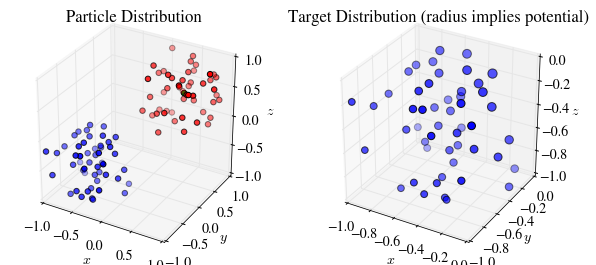

In [10]:
# plot spatial particle distribution
fig = pyplot.figure(figsize=(10,4.5))
# left plot
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter([target.x for target in targets], 
           [target.y for target in targets], 
           [target.z for target in targets], s=30, c='b')
ax.scatter([source.x for source in sources], 
           [source.y for source in sources], 
           [source.z for source in sources], s=30, c='r')

ax.scatter(center.x, center.y, center.z, s=30, c='g')

ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Particle Distribution')
# right plot
ax = fig.add_subplot(1,2,2, projection='3d')
scale = 100   # scale for dot size in scatter plot
ax.scatter([target.x for target in targets], 
           [target.y for target in targets], 
           [target.z for target in targets],
           s=phi_multi*scale, c='b')
ax.set_xlim3d(-1,0)
ax.set_ylim3d(-1,0)
ax.set_zlim3d(-1,0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Target Distribution (radius implies potential)');

Recall in the previous notebook, we use the same list of source particles and target particles, while since here we have separate list of sources and targets, we have to modify the direct summation module as follows.

In [11]:
def direct_sum(sources, targets):
    """Calculate the gravitational potential (target.phi) at each target 
    particle using direct summation method.

    Arguments:
        sources: the list of source objects in 'Particle' class
        targets: the list of target objects in 'Particle' class

    """
    for target in targets:
        for source in sources:
            r = target.distance(source)
            target.phi += source.m/r

In [12]:
direct_sum(sources, targets)
phi_direct = numpy.asarray([target.phi for target in targets])

Let's run the direct summation code and multipole expansion code respectively, and get a rough estimation about the time elapsed.

In [13]:
%timeit direct_sum(sources, targets)

100 loops, best of 3: 7.01 ms per loop


In [14]:
%%timeit
multipole = P2M(sources, center)
eval_potential(targets, multipole, center)

1000 loops, best of 3: 172 µs per loop


We found the multipole expansion consumes much less time than the 'brute-force' method, because we decouple the interaction term $\frac{m_j}{r_{ij}}$ into $A_k(j)\,B_k(i)$. Therefore, we can calculate the $A_k(j)$ outside the loop in targets $i$, saving us from double loop! If you increase the number of particles $n$, the speedup will be greater.



Now let's verify the accuracy of multipole expansion according the exact solution given by direct summation. We use $L^2$ relative error norm to assess the error:

$$\begin{equation}
err_{L^2} = \sqrt \frac{\sum \left(\Phi_{direct}-\Phi_{multi}\right)^2}{\sum \Phi_{direct}^2}
\end{equation}$$

In [15]:
err = numpy.sqrt(sum((phi_direct-phi_multi)**2)/sum(phi_direct**2))
print('L2 Norm error: {}'.format(err))

L2 Norm error: 0.008143520677042005


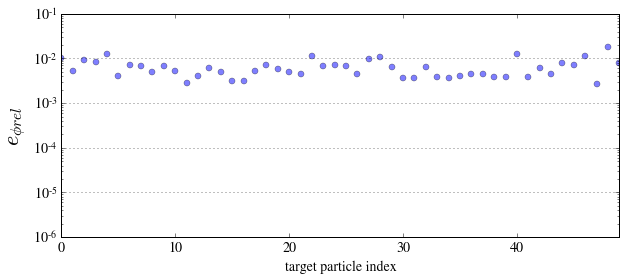

In [21]:
# plotting the relative error band
err_rel = abs((phi_multi - phi_direct) / phi_direct)
pyplot.figure(figsize=(10,4))
ax = pyplot.gca()
pyplot.plot(range(n), err_rel, 'bo', alpha=0.5)
pyplot.xlim(0,n-1)
pyplot.ylim(1e-6, 1e-1)
ax.yaxis.grid()
pyplot.xlabel('target particle index')
pyplot.ylabel('$e_{\phi rel}$', fontsize=22)
ax.set_yscale('log')

In the case where sources are close to the expansion center, and targets in a distance, we find this accelerated algorithm gives a very accurate estimation of the potentials at targets. Remember in the multipole expansion code, we first go over each source particles $j$ to evaluate the multipole the cell. That is why we refer this module as **Particle-to-Multipole** or **P2M** in the treecode.

##### Reference

1. R. Yokota, 12 Steps to a Fast Multipole Method on GPUs, Pan-American Advanced Studies Institute, Valparaiso, Chile, 3-14 January, 2011.
2. Raykar, V. C., "[A short primer on the fast multipole method: FMM tutorial](http://www.umiacs.umd.edu/labs/cvl/pirl/vikas/publications/FMM_tutorial.pdf),", University of Maryland, College Park, Apr. 8, 2006.

In [17]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./style/fmmstyle.css', 'r').read()
    return HTML(styles)
css_styling()